# Aerobicity phenotype: data analysis, processing, and visualization

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import os

import random
import requests

import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler

import torch

from feature_selection.feature_selection_utils import (
    mutual_info_features,
    random_forest_features,
    shap_features,
    xgboost_train_accur,
    xgboost_accur_select_features,
    plot_accuracy_metric,
    make_cog_descr#,
    # xgboost_accur_select_features_rand,
    # plot_accuracy_metric_rand
)

In [5]:
# Add the parent directory to sys.path (to import util function)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from utils.utils import read_aerob_data, pca_run_and_plot, tsne_plot

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RANDOM_SEED = 42

## 1. Read the dataset

In [14]:
#full data
X, y, full_data = read_aerob_data()

Read in 47894 GTDB representatives
Data without noise: 3161

Counts of y: shape: (2, 2)
┌──────────────┬──────┐
│ oxytolerance ┆ len  │
│ ---          ┆ ---  │
│ i32          ┆ u32  │
╞══════════════╪══════╡
│ 1            ┆ 2106 │
│ 0            ┆ 1055 │
└──────────────┴──────┘


In [15]:
#train
X_train, y_train, full_data_train = read_aerob_data(
    X_data_path='../data_aerob/input_data/train_data_phylum_tax_level', 
    y_data_path = '../data_aerob/input_data/train_annot_phylum_tax_level',
    bac_phylogeny_data_path='../data_preparation/gtdb_files/bac120_metadata_r202.tsv', 
    arch_phylogeny_data_path='../data_preparation/gtdb_files/ar122_metadata_r202.tsv',
    target_column = 'annotation')

# full_data_train

Read in 47894 GTDB representatives
Data without noise: 1563

Counts of y: shape: (2, 2)
┌────────────┬─────┐
│ annotation ┆ len │
│ ---        ┆ --- │
│ i32        ┆ u32 │
╞════════════╪═════╡
│ 1          ┆ 754 │
│ 0          ┆ 809 │
└────────────┴─────┘


In [16]:
#test
X_test, y_test, full_data_test = read_aerob_data(
    X_data_path='../data_aerob/input_data/test_data_phylum_tax_level', 
    y_data_path = '../data_aerob/input_data/test_annot_phylum_tax_level',
    bac_phylogeny_data_path='../data_preparation/gtdb_files/bac120_metadata_r202.tsv', 
    arch_phylogeny_data_path='../data_preparation/gtdb_files/ar122_metadata_r202.tsv',
    target_column = 'annotation')

# full_data_test

Read in 47894 GTDB representatives
Data without noise: 1598

Counts of y: shape: (2, 2)
┌────────────┬──────┐
│ annotation ┆ len  │
│ ---        ┆ ---  │
│ i32        ┆ u32  │
╞════════════╪══════╡
│ 0          ┆ 246  │
│ 1          ┆ 1352 │
└────────────┴──────┘


In [17]:
X_train =  torch.tensor(X_train.values)
y_train = torch.tensor(y_train)
X_test = torch.tensor(X_test.values)
y_test = torch.tensor(y_test)

X_train_np = np.array(X_train.cpu())
X_train_transposed = X_train_np.T

X_column_names = X.columns
n_cols = len(X_column_names)

## 2. PCA and tSNE projections

*All features*

**Colored by oxytolerance**

Data after PCA reduction: (3161, 20)
Explained variance ratio: [0.11369068 0.06242916 0.05329809 0.04972046 0.03812506 0.02856772
 0.02378797 0.02024784 0.01857993 0.01501786 0.01195041 0.01002442
 0.00853559 0.00788753 0.00746692 0.00698065 0.00635038 0.00614163
 0.00590446 0.00525903]
Total explained variance: 0.4999657969420641
Shape of the projected data = (3161, 2)


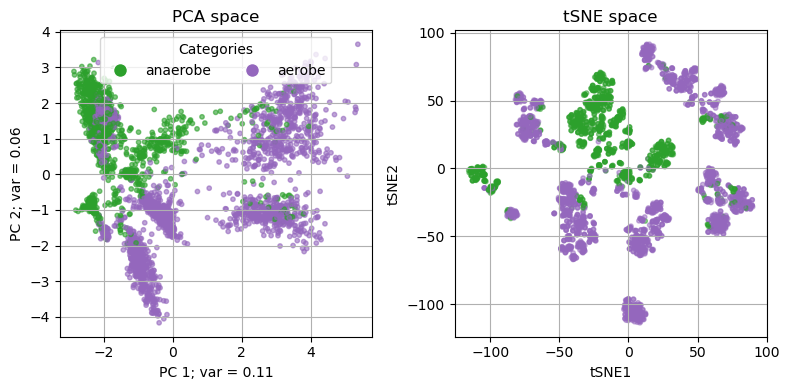

In [10]:
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
colors = ListedColormap(["tab:green", "tab:purple"])
category_names = full_data['oxytolerance']
pca_run_and_plot(X, n_compon, y, category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X, 30, 100, 42, y, colors);


# Display the plots
plt.tight_layout()  
plt.show()

**Colored by domain (bacteria vs archaea)**

Data after PCA reduction: (3161, 20)
Explained variance ratio: [0.11369068 0.06242916 0.05329809 0.04972046 0.03812506 0.02856772
 0.02378797 0.02024784 0.01857993 0.01501786 0.01195041 0.01002442
 0.0085356  0.00788749 0.00746712 0.0069807  0.00635057 0.00613987
 0.00590497 0.00525966]
Total explained variance: 0.49996560182007976
Shape of the projected data = (3161, 2)


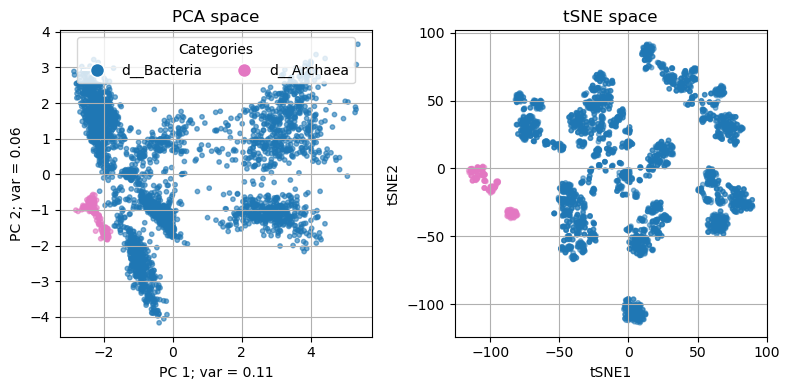

In [11]:
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
colors = ListedColormap(["tab:blue", "tab:pink"])
category_names = full_data['domain']
pca_run_and_plot(X, n_compon, [0 if a == 'd__Bacteria' else 1 for a in full_data['domain']],
                 category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X, 30, 100, 42, [0 if a == 'd__Bacteria' else 1 for a in full_data['domain']], colors);


# Display the plots
plt.tight_layout()  
plt.show()

**Colored by Phylum**

Data after PCA reduction: (3161, 20)
Explained variance ratio: [0.11369068 0.06242916 0.05329809 0.04972046 0.03812506 0.02856772
 0.02378797 0.02024784 0.01857993 0.01501786 0.01195041 0.01002442
 0.0085356  0.00788753 0.00746708 0.00698072 0.00635043 0.00614147
 0.00590532 0.0052608 ]
Total explained variance: 0.4999685638067801
Shape of the projected data = (3161, 2)


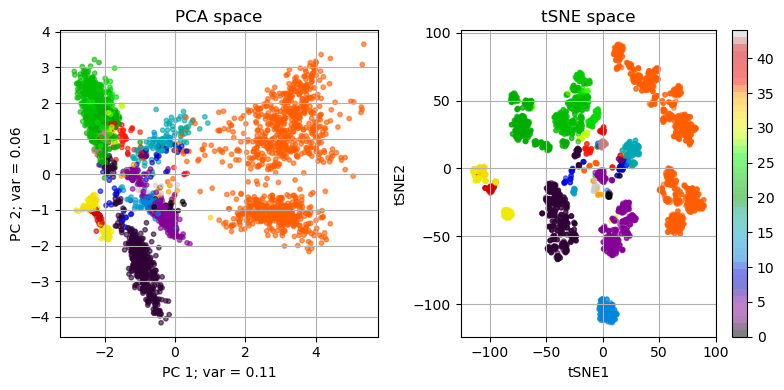

In [12]:
label_encoder = LabelEncoder()

plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
colors = None
category_names = full_data['phylum']
pca_run_and_plot(X, n_compon, 
                 label_encoder.fit_transform(full_data['phylum']),
                 category_names, colors);
plt.legend().remove()
# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X, 30, 100, 42, 
          label_encoder.fit_transform(full_data['phylum']), 
          colors);


# Display the plots
plt.legend().remove()
plt.tight_layout()  
plt.show()

## 3. XGBoost training and feature selection

In [18]:
cv_accuracy_scores, test_accuracy_scores = xgboost_train_accur(X_train, y_train, X_test, y_test, DEVICE)
print(f"XGBoost baseline test accuracy (all features) = {test_accuracy_scores}")
print(f"XGBoost cv_accuracy (all features) = {test_accuracy_scores}")

XGBoost baseline test accuracy (all features) = {'accuracy': 0.9474342928660826, 'precision': np.float64(0.9554597701149425), 'recall': np.float64(0.9837278106508875), 'f1': np.float64(0.9693877551020408), 'roc_auc': np.float64(0.9400376437196325)}
XGBoost cv_accuracy (all features) = {'accuracy': 0.9474342928660826, 'precision': np.float64(0.9554597701149425), 'recall': np.float64(0.9837278106508875), 'f1': np.float64(0.9693877551020408), 'roc_auc': np.float64(0.9400376437196325)}


In [19]:
cv_accur_arr_rand, test_accur_arr_rand, num_feat_rand = xgboost_accur_select_features_rand(
    X_train, X_test, 
    y_train, y_test, 
    feat_step=50, DEVICE=DEVICE, feat_removal=False,
    n_cols=n_cols, reps=5)

In [20]:
cv_accur_arr_rand_rem, test_accur_arr_rand_rem, num_feat_rand_rem = xgboost_accur_select_features_rand(
    X_train, X_test, 
    y_train, y_test,
    feat_step=50, DEVICE=DEVICE, feat_removal=True,
    n_cols=n_cols, reps=5)

### 3.1 Feature selection with Mutual Information

In [21]:
sorted_cog_idx_by_mi, sorted_mi, sorted_names = mutual_info_features(X_train.cpu(), y_train.cpu(), X_column_names)

In [22]:
# Select the top N features
N = 10
top_N_indices = sorted_cog_idx_by_mi[:N]
top_N_mi = sorted_mi[:N]
top_N_names_by_mi = sorted_names[:N]
top_feat_mi_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_mi[:N]]

print(f"Top {N} COGs:", top_N_names_by_mi)

Top 10 COGs: ['COG1612', 'COG1592', 'COG0109', 'COG0276', 'COG0026', 'COG0400', 'COG1328', 'COG1054', 'COG0508', 'COG0493']


Data after PCA reduction: (1563, 5)
Explained variance ratio: [0.65075387 0.06942549 0.0580325  0.05217575 0.0483915 ]
Total explained variance: 0.87877909427532


python3.12(15425) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Shape of the projected data = (1563, 2)


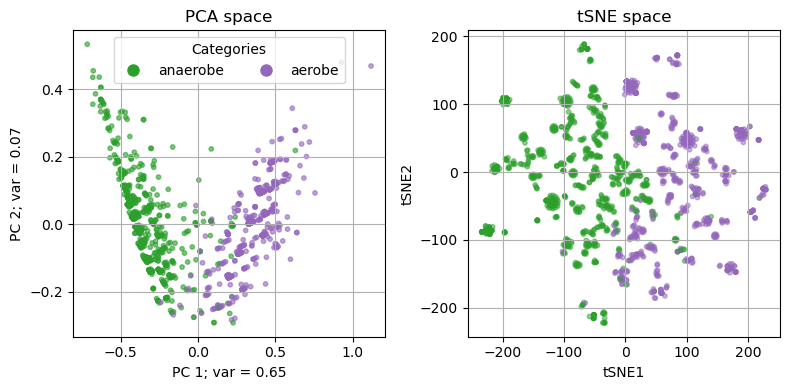

In [23]:
plt.figure(figsize=(8, 4))
X_top_feat = np.array([X_train_transposed[i] for i in sorted_cog_idx_by_mi[:N]])

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 5 
colors = ListedColormap(["tab:green", "tab:purple"])
category_names = full_data['oxytolerance']
pca_run_and_plot(X_top_feat.T, n_compon, y_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_top_feat.T, 10, 50, 42, y_train.cpu(),colors);

# Display the plots
plt.tight_layout()  
plt.show()


In [24]:
y_label_train = y_train
y_label_test = y_test

X_val_train, X_val_test = X_train.cpu(), X_test.cpu()
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_val_train)
X_val_test_scaled = scaler.fit_transform(X_val_test)

feat_step = 5
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_mi, feat_step, DEVICE, feat_removal)       

feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat_rem = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_mi, feat_step, DEVICE, feat_removal)       

In [25]:
print(cv_accur_arr[0])
print(test_accur_arr[0])

{'accuracy': np.float64(0.9603301384451545), 'precision': np.float64(0.968378203737907), 'recall': np.float64(0.9495805739514349), 'f1': np.float64(0.9585146097042276), 'roc_auc': np.float64(0.9608189491691427)}
{'accuracy': 0.8385481852315394, 'precision': np.float64(0.9643463497453311), 'recall': np.float64(0.8402366863905325), 'f1': np.float64(0.8980237154150198), 'roc_auc': np.float64(0.8273500264588444)}


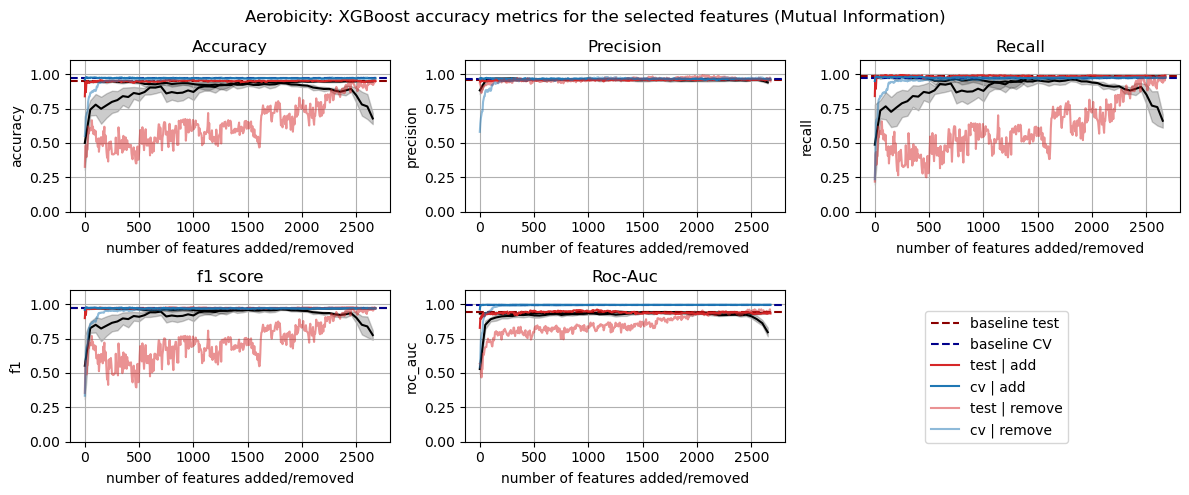

In [26]:
fig = plt.figure(figsize=(12, 5))
plt.subplot(2, 3, 1)
metric = 'accuracy'
plot_accuracy_metric_rand(metric, test_accur_arr_rand, num_feat_rand)
plot_accuracy_metric_rand(metric, test_accur_arr_rand_rem, num_feat_rand_rem)
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Accuracy")
plt.grid()

plt.subplot(2, 3, 2)
metric = 'precision'
plot_accuracy_metric_rand(metric, test_accur_arr_rand, num_feat_rand)
plot_accuracy_metric_rand(metric, test_accur_arr_rand_rem, num_feat_rand_rem)
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Precision")
plt.grid()

plt.subplot(2, 3, 3)
metric = 'recall'
plot_accuracy_metric_rand(metric, test_accur_arr_rand, num_feat_rand)
plot_accuracy_metric_rand(metric, test_accur_arr_rand_rem, num_feat_rand_rem)
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Recall")
plt.grid()

plt.subplot(2, 3, 4)
metric = 'f1'
plot_accuracy_metric_rand(metric, test_accur_arr_rand, num_feat_rand)
plot_accuracy_metric_rand(metric, test_accur_arr_rand_rem, num_feat_rand_rem)
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("f1 score")
plt.grid()

plt.subplot(2, 3, 5)
metric = 'roc_auc'
plot_accuracy_metric_rand(metric, test_accur_arr_rand, num_feat_rand)
plot_accuracy_metric_rand(metric, test_accur_arr_rand_rem, num_feat_rand_rem)
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Roc-Auc")
plt.grid()

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave top 5% of figure for suptitle
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1))  # near bottom-right of full figure

plt.suptitle("Aerobicity: XGBoost accuracy metrics for the selected features (Mutual Information)");

### 3.2 Feature selection with Random Forest

In [27]:
sorted_cog_idx_by_rand_forest, sorted_importances, sorted_names = random_forest_features(X_val_train.cpu(), y_label_train.cpu(), X_column_names)

Original feature count: 2677, Selected feature count: 252


In [28]:
# Select the top N features
N = 10
top_N_indices = sorted_cog_idx_by_rand_forest[:N]
top_N_importances = sorted_importances[:N]
top_N_names_by_rand_forest = sorted_names[:N]
top_feat_rand_forest_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_rand_forest[:N]]
print(f"Top {N} COGs:", top_N_names_by_rand_forest)

Top 10 COGs: ['COG1592', 'COG1328', 'COG0109', 'COG0276', 'COG1252', 'COG2322', 'COG0623', 'COG1612', 'COG0479', 'COG0369']


In [29]:
X_top_feat = np.array([X_train_transposed[i] for i in sorted_cog_idx_by_rand_forest[:N]])

Data after PCA reduction: (1563, 5)
Explained variance ratio: [0.60739568 0.09045017 0.08043038 0.06037606 0.04990554]
Total explained variance: 0.8885578331319796
Shape of the projected data = (1563, 2)


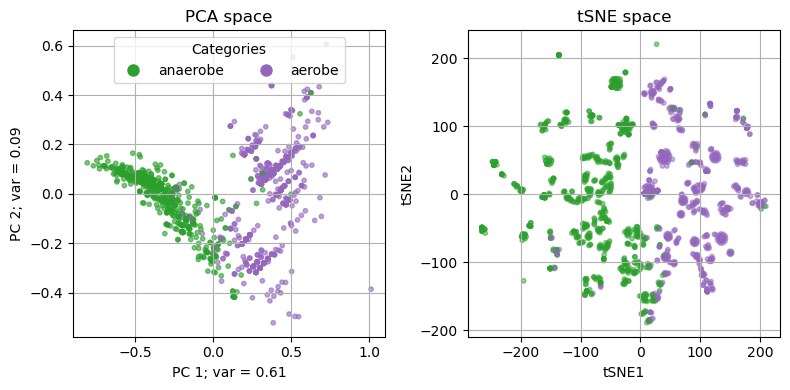

In [30]:
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 5
colors = ListedColormap(["tab:green", "tab:purple"])
category_names = full_data['oxytolerance']
pca_run_and_plot(X_top_feat.T, n_compon, y_label_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_top_feat.T, 10, 50, 42, y_label_train.cpu(),colors);

# Display the plots
plt.tight_layout()  
plt.show()

In [31]:
X_val_train, X_val_test = X_val_train.cpu(), X_val_test.cpu()
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_val_train)
X_val_test_scaled = scaler.fit_transform(X_val_test)

feat_step = 5
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_rand_forest, feat_step, DEVICE, feat_removal)       

feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_rand_forest, feat_step, DEVICE, feat_removal)       

In [32]:
print(cv_accur_arr[0])
print(test_accur_arr[0])

{'accuracy': np.float64(0.940509543704432), 'precision': np.float64(0.9143967692224184), 'recall': np.float64(0.968167770419426), 'f1': np.float64(0.9402136401786484), 'roc_auc': np.float64(0.9501902541026578)}
{'accuracy': 0.867334167709637, 'precision': np.float64(0.9266467065868264), 'recall': np.float64(0.915680473372781), 'f1': np.float64(0.9211309523809523), 'roc_auc': np.float64(0.7702620628277288)}


Text(0.5, 0.98, 'Aerobicity: XGBoost accuracy metrics for the selected features (Random Forest)')

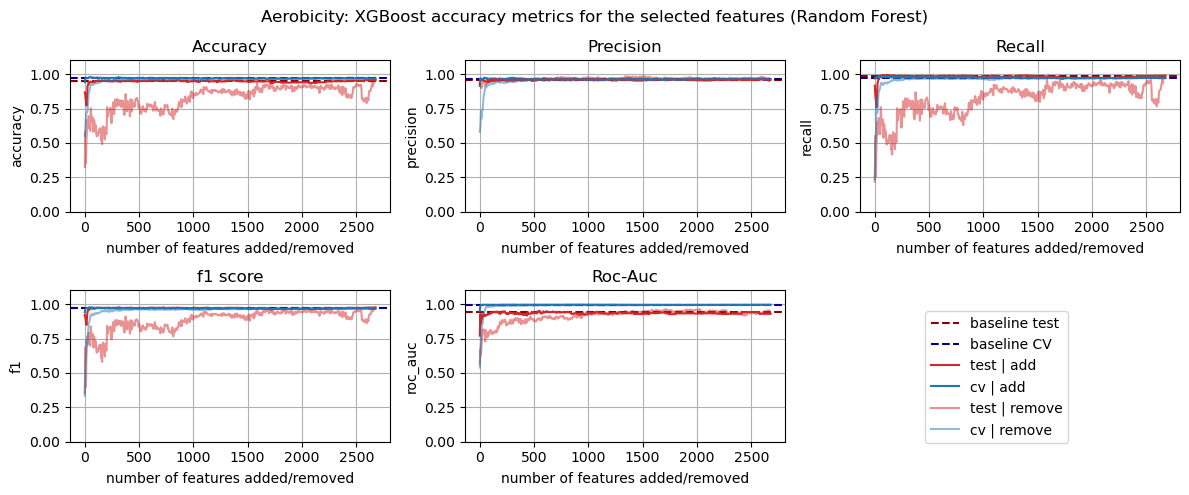

In [33]:
fig = plt.figure(figsize=(12, 5))
plt.subplot(2, 3, 1)
metric = 'accuracy'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Accuracy")
plt.grid()

plt.subplot(2, 3, 2)
metric = 'precision'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Precision")
plt.grid()

plt.subplot(2, 3, 3)
metric = 'recall'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Recall")
plt.grid()

plt.subplot(2, 3, 4)
metric = 'f1'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("f1 score")
plt.grid()

plt.subplot(2, 3, 5)
metric = 'roc_auc'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Roc-Auc")
plt.grid()

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave top 5% of figure for suptitle
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1))  # near bottom-right of full figure

plt.suptitle("Aerobicity: XGBoost accuracy metrics for the selected features (Random Forest)")

### 3.3 SHAP values

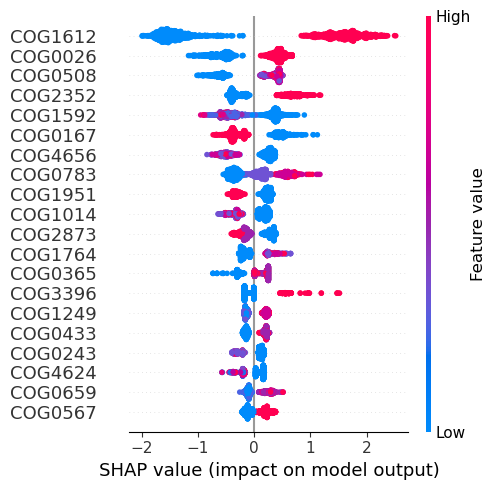

In [38]:
sorted_cog_idx_by_shap, sorted_shap, sorted_names = shap_features(X_val_train.cpu(), y_label_train.cpu(), X_column_names, DEVICE) 

In [39]:
# Select the top N features
N = 10
top_N_indices = sorted_cog_idx_by_shap[:N]
top_N_mi = sorted_shap[:N]
top_N_names_by_shap = sorted_names[:N]
top_feat_shap_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_shap[:N]]

print(f"Top {N} COGs:", top_N_names_by_shap)

Top 10 COGs: ['COG1612', 'COG0026', 'COG0508', 'COG2352', 'COG1592', 'COG0167', 'COG4656', 'COG0783', 'COG1951', 'COG1014']


Data after PCA reduction: (1563, 5)
Explained variance ratio: [0.55811078 0.09541662 0.06895719 0.06347323 0.05643197]
Total explained variance: 0.8423897919592606
Shape of the projected data = (1563, 2)


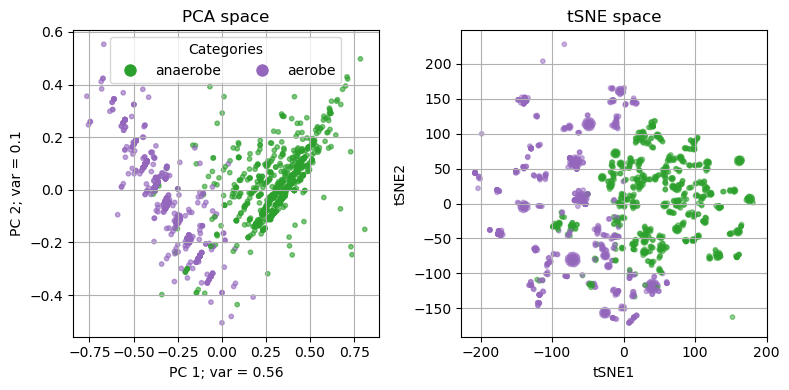

In [40]:
plt.figure(figsize=(8, 4))
X_top_feat = np.array([X_train_transposed[i] for i in sorted_cog_idx_by_shap[:N]])

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 5 
colors = ListedColormap(["tab:green", "tab:purple"])
category_names = full_data['oxytolerance']

pca_run_and_plot(X_top_feat.T, n_compon, y_label_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_top_feat.T, 10, 50, 42, y_label_train.cpu(),colors);

# Display the plots
plt.tight_layout()  
plt.show()

In [41]:
X_val_train, X_val_test = X_val_train.cpu(), X_val_test.cpu()
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_val_train)
X_val_test_scaled = scaler.fit_transform(X_val_test)

feat_step = 5
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_shap, feat_step, DEVICE, feat_removal)       

feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat_rem = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_shap, feat_step, DEVICE, feat_removal)       

Text(0.5, 0.98, 'Aerobicity: XGBoost accuracy metrics for the selected features (SHAP values)')

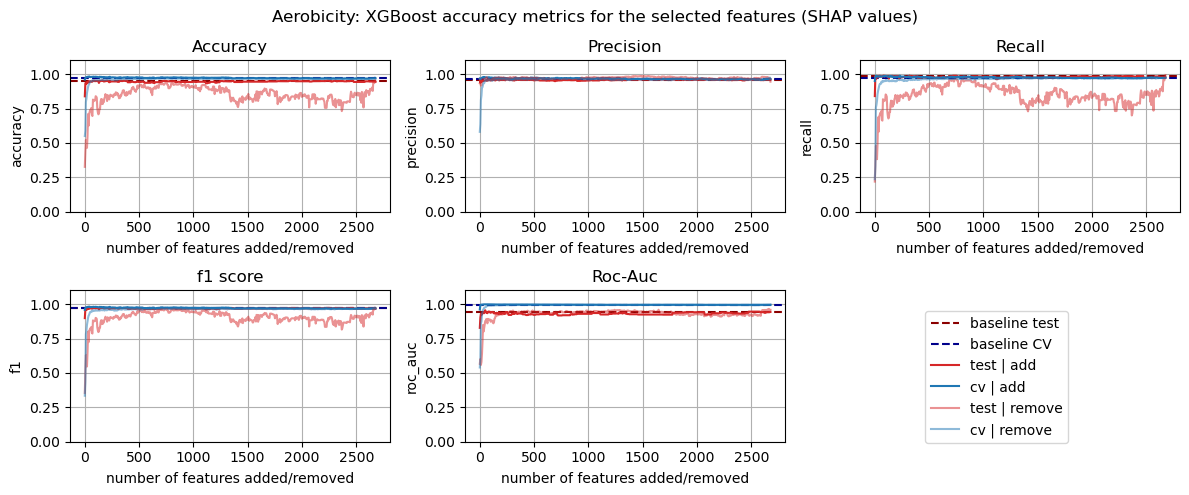

In [42]:
fig = plt.figure(figsize=(12, 5))
plt.subplot(2, 3, 1)
metric = 'accuracy'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Accuracy")
plt.grid()

plt.subplot(2, 3, 2)
metric = 'precision'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Precision")
plt.grid()

plt.subplot(2, 3, 3)
metric = 'recall'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Recall")
plt.grid()

plt.subplot(2, 3, 4)
metric = 'f1'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("f1 score")
plt.grid()

plt.subplot(2, 3, 5)
metric = 'roc_auc'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Roc-Auc")
plt.grid()

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave top 5% of figure for suptitle
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1))  # near bottom-right of full figure

plt.suptitle("Aerobicity: XGBoost accuracy metrics for the selected features (SHAP values)")

## 4. Feature comparison

In [43]:
data = {
    'MI': top_N_names_by_mi,
    'RandomForest': top_N_names_by_rand_forest,
    'SHAP': top_N_names_by_shap
}

df = pd.DataFrame(data)

df

,MI,RandomForest,SHAP
0,COG1612,COG1592,COG1612
1,COG1592,COG1328,COG0026
2,COG0109,COG0109,COG0508
3,COG0276,COG0276,COG2352
4,COG0026,COG1252,COG1592
5,COG0400,COG2322,COG0167
6,COG1328,COG0623,COG4656
7,COG1054,COG1612,COG0783
8,COG0508,COG0479,COG1951
9,COG0493,COG0369,COG1014


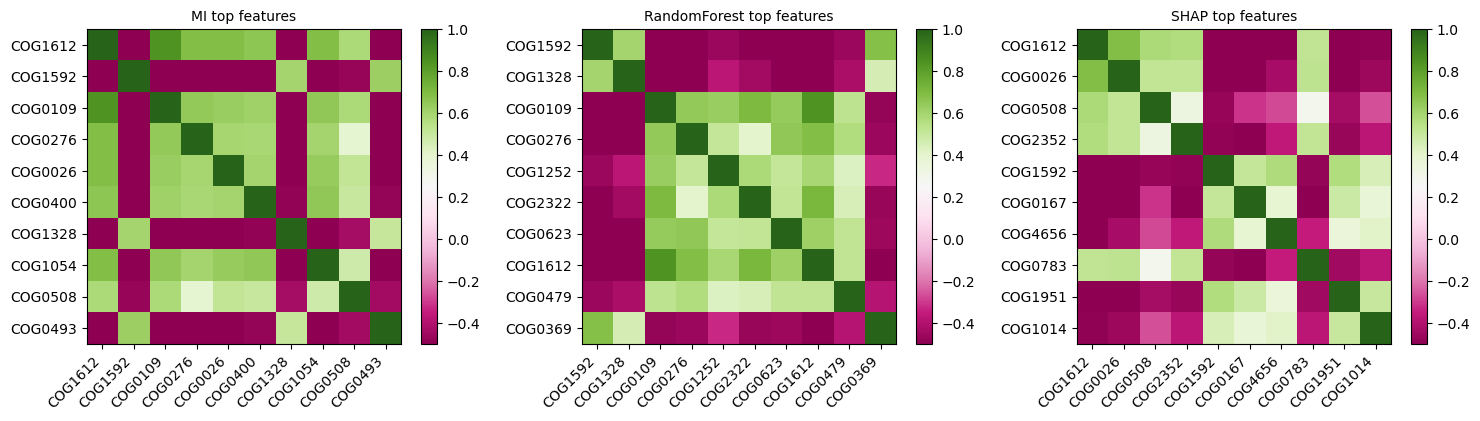

In [44]:
plt.figure(figsize=(15, 4))

vmin, vmax = -0.5, 1 #-0.6

# Correlation matrix for MI top features
plt.subplot(1, 3, 1) 
correlation_matrix = np.corrcoef(top_feat_mi_counts)
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("MI top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_mi)), labels=top_N_names_by_mi, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_mi)), labels=top_N_names_by_mi)
plt.colorbar()

# Correlation matrix for RandomForest top features
plt.subplot(1, 3, 2) 
correlation_matrix = np.corrcoef(top_feat_rand_forest_counts) 
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("RandomForest top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_rand_forest)), labels=top_N_names_by_rand_forest, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_rand_forest)), labels=top_N_names_by_rand_forest)
plt.colorbar()

# Correlation matrix for SHAP top features
plt.subplot(1, 3, 3) 
correlation_matrix = np.corrcoef(top_feat_shap_counts) 
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("SHAP top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_shap)), labels=top_N_names_by_shap, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_shap)), labels=top_N_names_by_shap)
plt.colorbar()

# Display the plots
plt.tight_layout()  
plt.show()

In [47]:
make_cog_descr(df)

,MI,RandomForest,SHAP
0,COG1612: Heme A synthase,COG1592: Rubrerythrin,COG1612: Heme A synthase
1,COG1592: Rubrerythrin,COG1328: Anaerobic ribonucleoside-triphosphate...,COG0026: Phosphoribosylaminoimidazole carboxyl...
2,COG0109: Polyprenyltransferase (heme O synthase),COG0109: Polyprenyltransferase (heme O synthase),COG0508: Pyruvate/2-oxoglutarate dehydrogenase...
3,COG0276: Protoheme ferro-lyase (ferrochelatase),COG0276: Protoheme ferro-lyase (ferrochelatase),COG2352: Phosphoenolpyruvate carboxylase
4,COG0026: Phosphoribosylaminoimidazole carboxyl...,"COG1252: NADH dehydrogenase, FAD-containing su...",COG1592: Rubrerythrin
5,COG0400: Palmitoyl-CoA esterase,COG2322: Cytochrome oxidase assembly protein C...,COG0167: Dihydroorotate dehydrogenase
6,COG1328: Anaerobic ribonucleoside-triphosphate...,COG0623: Enoyl-[acyl-carrier-protein] reductas...,COG4656: Na+-translocating ferredoxin:NAD+ oxi...
7,"COG1054: tRNA U34 5'-hydroxylase TrhO, rhodane...",COG1612: Heme A synthase,COG0783: DNA-binding ferritin-like chromatin p...
8,COG0508: Pyruvate/2-oxoglutarate dehydrogenase...,COG0479: Succinate dehydrogenase/fumarate redu...,COG1951: Tartrate dehydratase alpha subunit/Fu...
9,COG0493: NADPH-dependent glutamate synthase be...,COG0369: Flavoprotein (flavin reductase) subun...,COG1014: Pyruvate:ferredoxin oxidoreductase or...
